<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Checking out files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:35<00:00, 81.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:02<00:00, 231MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:04<00:00, 139MB/s]


In [36]:
import torchvision
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
!pip install facenet-pytorch --quiet
from facenet_pytorch import MTCNN
from PIL import Image
import cv2

In [14]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        with open(self.text_path, 'r') as f:
            self.text = f.readlines()
        self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)
    

In [24]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((640, 1280)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
    ])
MSCTD_train = MSCTD(root='.', split='train', image_transform=image_transform)
MSCTD_dev = MSCTD(root='.', split='dev', image_transform=image_transform)
MSCTD_test = MSCTD(root='.', split='test', image_transform=image_transform)

In [26]:
batch_size = 32
train_loader = DataLoader(MSCTD_train, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(MSCTD_dev, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(MSCTD_test, batch_size=batch_size, shuffle=False)

In [28]:
# define a function that given the image and the bounding boxes, and their sentiments, crops the image and returns the cropped image and the sentiment
transform = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x.permute(2, 0, 1)),
    torchvision.transforms.Resize((160, 160)),
    torchvision.transforms.Lambda(lambda x: x.permute(1, 2, 0))
    ])
def face_extractor(image, boxes, sentiments):
    """
    :param image: image tensor of shape (batch_size, height, width, channels)
    :param boxes: bounding boxes for the faces of shape (batch_size, num_faces, 4) where 4 is (x1, y1, x2, y2). Note that some images may not have any faces
    :param sentiments: sentiment for the faces of shape (batch_size, )
    :return: cropped image and sentiment 
    """
    cropped_images = []
    cropped_sentiments = []
    for i in range(image.shape[0]):
        current_image = image[i]
        current_sentiment = sentiments[i]
        if boxes[i] is not None:
            for j in range(boxes[i].shape[0]):
                current_box = boxes[i][j]
                x1, y1, x2, y2 = current_box
                x1, y1, x2, y2 = max(int(x1), 0), max(int(y1), 0), max(int(x2), 0), max(int(y2), 0)
                resized_image = transform(current_image[y1:y2, x1:x2])
                cropped_images.append(resized_image)
                cropped_sentiments.append(current_sentiment)
    return cropped_images, cropped_sentiments

In [ ]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 
def num_faces(boxes):
  return [0 if i is None else len(i) for i in boxes]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(keep_all=True, device=device)
train_faces_per_img = []
dev_faces_per_img = []
test_faces_per_img = []
with torch.no_grad():
  for image, text, sentiment in dev_loader:
    print(image.shape)
    image = image.to(device)
    boxes, probs = mtcnn.detect(image)
    print(boxes.shape)
    print(boxes)
    print(probs.shape)
    print(probs)
    break
    

torch.Size([439, 334, 3])
torch.Size([160, 160, 3])
torch.Size([543, 366, 3])
torch.Size([160, 160, 3])
torch.Size([447, 339, 3])
torch.Size([160, 160, 3])
torch.Size([447, 339, 3])
torch.Size([160, 160, 3])
torch.Size([102, 75, 3])
torch.Size([160, 160, 3])
torch.Size([99, 71, 3])
torch.Size([160, 160, 3])
torch.Size([127, 71, 3])
torch.Size([160, 160, 3])
torch.Size([356, 278, 3])
torch.Size([160, 160, 3])
torch.Size([361, 279, 3])
torch.Size([160, 160, 3])
torch.Size([34, 24, 3])
torch.Size([160, 160, 3])
torch.Size([24, 20, 3])
torch.Size([160, 160, 3])
torch.Size([23, 17, 3])
torch.Size([160, 160, 3])
torch.Size([401, 378, 3])
torch.Size([160, 160, 3])
torch.Size([415, 321, 3])
torch.Size([160, 160, 3])
torch.Size([248, 198, 3])
torch.Size([160, 160, 3])
torch.Size([249, 194, 3])
torch.Size([160, 160, 3])
torch.Size([544, 583, 3])
torch.Size([160, 160, 3])
torch.Size([393, 301, 3])
torch.Size([160, 160, 3])
torch.Size([346, 267, 3])
torch.Size([160, 160, 3])
torch.Size([399, 298, 

In [109]:
faces[0][4].shape

torch.Size([160, 160, 3])

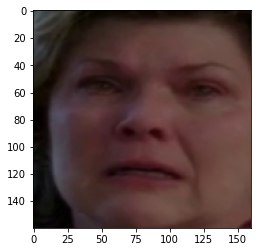

In [111]:
plt.imshow(faces[0][15].cpu().numpy())